In [ ]:
from io import BytesIO

import matplotlib.pyplot as plt
import numpy as np
import pynvml
import requests
import scipy.ndimage
import torch
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
from torch.amp import GradScaler, autocast
from torchvision import transforms
from tqdm import tqdm

In [226]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

torch.backends.cudnn.benchmark = True

if torch.cuda.is_available():
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")
    print(
        f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB"
    )
    print(f"CUDA Version: {torch.version.cuda}")
else:
    print("CUDA not available, using CPU")

Using GPU: Tesla P100-PCIE-16GB
GPU Memory: 17.06 GB
CUDA Version: 12.4


In [227]:
IMG_PATH = "https://www.nylabone.com/-/media/project/oneweb/nylabone/images/dog101/10-intelligent-dog-breeds/golden-retriever-tongue-out.jpg?h=430&w=710&hash=7FEB820D235A44B76B271060E03572C7"
IMG_SIZE = 28
PATCH_SIZE = 7
EMBEDDING_SIZE = 64
NUM_HEADS = 4
NUM_LAYERS = 3
NUM_CLASSES = 10
DROPOUT_RATE = 0.1

NUM_EPOCHS = 30
LEARNING_RATE = 3e-4
BATCH_SIZE = 256
GRADIENT_ACCUMULATION_STEPS = 4
NUM_WORKERS = 4
PIN_MEMORY = True
USE_AMP = True

In [228]:
transform = transforms.Compose(
    [transforms.Resize((IMG_SIZE, IMG_SIZE)), transforms.ToTensor()]
)
img_tensor = transform(Image.open(BytesIO(requests.get(IMG_PATH).content)))
img_tensor.shape

torch.Size([3, 28, 28])

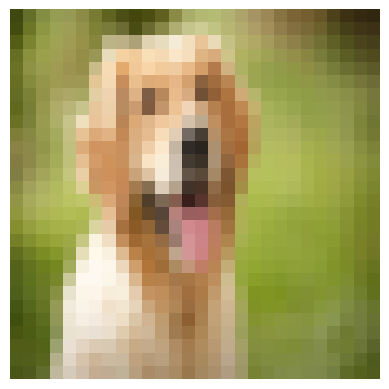

In [229]:
plt.imshow(img_tensor.permute(1, 2, 0))
plt.axis("off")
plt.show()

In [230]:
batch = img_tensor.unsqueeze(0).to(device)

# Vision Transformer

In [231]:
class PatchEmbeddings(nn.Module):
    def __init__(
        self, in_channels: int, image_size: int, patch_size: int, embedding_size: int
    ):
        super().__init__()
        self.in_channels = in_channels
        self.patch_size = patch_size
        self.embedding_size = embedding_size
        self.patch_num = (image_size // patch_size) ** 2

        # Equivalent of: patch flatten + linear projection
        self.projection = nn.Conv2d(
            in_channels=in_channels,
            out_channels=embedding_size,
            kernel_size=patch_size,
            stride=patch_size,
        )

    def forward(self, x):
        x = self.projection(x)  # [btach_size, embedding_size, patch_num, patch_num]
        x = x.flatten(2).transpose(1, 2)  # [batch_size, patch_num, embedding_size]
        return x

In [232]:
patch_embeddings = PatchEmbeddings(
    in_channels=batch.shape[1],
    image_size=IMG_SIZE,
    patch_size=PATCH_SIZE,
    embedding_size=EMBEDDING_SIZE,
).to(device)

patch_embeddings(batch).shape  # [batch_size, patch_num, embedding_size]

torch.Size([1, 16, 64])

In [233]:
class EmbeddingLayer(nn.Module):
    def __init__(
        self, in_channels, image_size, patch_size, embedding_size, dropout_rate=0.1
    ):
        super().__init__()
        self.patch_embeddings = PatchEmbeddings(
            in_channels, image_size, patch_size, embedding_size
        )
        self.positional_embeddings = nn.Parameter(
            torch.randn(1, self.patch_embeddings.patch_num + 1, embedding_size)
        )
        self.cls_token = nn.Parameter(torch.randn(1, 1, embedding_size))
        self.patch_num = self.patch_embeddings.patch_num + 1
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        cls_tokens = self.cls_token.expand((x.shape[0], 1, -1))
        x = self.patch_embeddings(x)
        x = torch.cat((cls_tokens, x), dim=1)
        x = x + self.positional_embeddings
        return self.dropout(x)

In [234]:
embedding_layer = EmbeddingLayer(
    in_channels=batch.shape[1],
    image_size=IMG_SIZE,
    patch_size=PATCH_SIZE,
    embedding_size=EMBEDDING_SIZE,
).to(device)

embedding_layer(batch).shape  # [batch_size, patch_num + 1, embedding_size]

torch.Size([1, 17, 64])

In [235]:
class AttentionLayer(nn.Module):
    def __init__(
        self, sequence_length, embedding_size, num_heads, dropout_rate=0.1, mask=False
    ):
        super().__init__()

        assert embedding_size % num_heads == 0, (
            "embedding_size must be divisible by num_heads"
        )

        self.mask = mask
        self.num_heads = num_heads
        self.head_size = embedding_size // num_heads
        self.sequence_length = sequence_length
        self.scale = self.head_size**-0.5

        self.embedding_size = embedding_size
        self.query_dense = nn.Linear(embedding_size, embedding_size)
        self.key_dense = nn.Linear(embedding_size, embedding_size)
        self.value_dense = nn.Linear(embedding_size, embedding_size)
        self.output_dense = nn.Linear(embedding_size, embedding_size)
        self.attn_dropout = nn.Dropout(dropout_rate)
        self.proj_dropout = nn.Dropout(dropout_rate)

    def split_heads(self, x):
        B, S, _ = x.size()
        return x.view(B, S, self.num_heads, self.head_size).transpose(1, 2)

    def forward(self, x):
        B, S, _ = x.size()

        Q = self.query_dense(x)
        K = self.key_dense(x)
        V = self.value_dense(x)

        Q_heads = self.split_heads(Q)  # (B, H, S, E/H)
        K_heads = self.split_heads(K)  # (B, H, S, E/H)
        V_heads = self.split_heads(V)  # (B, H, S, E/H)

        attention = (Q_heads @ K_heads.transpose(-2, -1)) * self.scale  # (B, H, S, S)

        if self.mask:
            mask = torch.tril(torch.ones(S, S, device=x.device)).view(1, 1, S, S)
            attention = attention.masked_fill(mask == 0, float("-inf"))

        attention_weights = F.softmax(attention, dim=-1)

        attention = self.attn_dropout(attention_weights) @ V_heads  # (B, H, S, E/H)

        out = attention.transpose(1, 2).contiguous().view(B, S, -1)
        out = self.output_dense(out)
        return self.proj_dropout(out), attention_weights

In [236]:
class FeedForward(nn.Module):
    def __init__(self, embedding_size, hidden_size, dropout_rate=0.1):
        super().__init__()
        self.fc1 = nn.Linear(embedding_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, embedding_size)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        x = self.dropout(F.gelu(self.fc1(x)))
        x = self.dropout(self.fc2(x))
        return x

In [237]:
class TransformerBlock(nn.Module):
    def __init__(
        self,
        sequence_length,
        embedding_size,
        num_heads,
        mlp_ratio=4.0,
        dropout_rate=0.1,
    ):
        super().__init__()
        self.norm1 = nn.LayerNorm(embedding_size)
        self.attention_layer = AttentionLayer(
            sequence_length,
            embedding_size,
            num_heads,
            dropout_rate=dropout_rate,
            mask=False,
        )
        self.norm2 = nn.LayerNorm(embedding_size)
        self.feed_forward = FeedForward(
            embedding_size, int(embedding_size * mlp_ratio), dropout_rate=dropout_rate
        )
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        attention, attention_weights = self.attention_layer(self.norm1(x))
        x = x + attention
        x = x + self.feed_forward(self.norm2(x))
        return x, attention_weights

In [238]:
class VisionTransformer(nn.Module):
    def __init__(
        self,
        in_channels: int,
        image_size: int,
        patch_size: int,
        embedding_size: int,
        num_heads: int,
        num_layers: int,
        mlp_ratio: float = 4.0,
        dropout_rate: float = 0.1,
    ):
        super().__init__()
        self.num_layers = num_layers
        self.num_heads = num_heads
        self.patch_size = patch_size
        self.image_size = image_size
        self.embedding_layer = EmbeddingLayer(
            in_channels, image_size, patch_size, embedding_size, dropout_rate
        )
        self.transformer_blocks = nn.ModuleList(
            [
                TransformerBlock(
                    self.embedding_layer.patch_num,
                    embedding_size,
                    num_heads,
                    mlp_ratio,
                    dropout_rate,
                )
                for _ in range(num_layers)
            ]
        )
        self.norm = nn.LayerNorm(embedding_size)

    def forward(self, x):
        x = self.embedding_layer(x)  # [batch_size, patch_num + 1, embedding_size]
        attention_maps = []

        for transformer_block in self.transformer_blocks:
            x, attention_weights = transformer_block(x)
            attention_maps.append(attention_weights)

        x = self.norm(x)

        # [batch_size, patch_num + 1, embedding_size], [num_layers, num_heads, patch_num + 1, patch_num + 1]
        return x, attention_maps

In [239]:
class VisionTransformerClassifier(nn.Module):
    def __init__(
        self,
        in_channels: int,
        image_size: int,
        patch_size: int,
        embedding_size: int,
        num_heads: int,
        num_layers: int,
        num_classes: int,
        mlp_ratio: float = 4.0,
        dropout_rate: float = 0.1,
    ):
        super().__init__()
        self.vit = VisionTransformer(
            in_channels,
            image_size,
            patch_size,
            embedding_size,
            num_heads,
            num_layers,
            mlp_ratio,
            dropout_rate,
        )

        self.mlp_head = nn.Sequential(
            nn.Linear(embedding_size, embedding_size),
            nn.GELU(),
            nn.Dropout(dropout_rate),
            nn.Linear(embedding_size, num_classes),
        )
        self.patch_size = patch_size
        self.image_size = image_size

    def forward(self, x):
        x, attention_maps = self.vit(
            x
        )  # [batch_size, patch_num + 1, embedding_size], attention_maps
        cls_token = x[:, 0]  # [batch_size, embedding_size]
        logits = self.mlp_head(cls_token)  # [batch_size, num_classes]
        probs = F.softmax(logits, dim=-1)
        return probs, attention_maps

In [240]:
vit = VisionTransformerClassifier(
    in_channels=img_tensor.shape[0],
    image_size=IMG_SIZE,
    patch_size=PATCH_SIZE,
    embedding_size=EMBEDDING_SIZE,
    num_heads=NUM_HEADS,
    num_layers=NUM_LAYERS,
    num_classes=NUM_CLASSES,
    dropout_rate=DROPOUT_RATE,
).to(device)

predicted, attention_maps = vit(batch)
predicted.shape, len(attention_maps), attention_maps[0].shape

(torch.Size([1, 10]), 3, torch.Size([1, 4, 17, 17]))

# Training

In [241]:
import torchvision

mnist = torchvision.datasets.MNIST("./data", train=True, download=True)

train_transform = transforms.Compose(
    [
        transforms.RandomAffine(degrees=10, translate=(0.1, 0.1)),
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,)),
    ]
)

test_transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))]
)

train_dataset = torchvision.datasets.MNIST(
    "./data", train=True, download=True, transform=train_transform
)
test_dataset = torchvision.datasets.MNIST(
    "./data", train=False, download=True, transform=test_transform
)

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY,
    prefetch_factor=2,
    persistent_workers=True,
)
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY
)

In [242]:
next(iter(train_loader))[0].shape

torch.Size([256, 1, 28, 28])

In [243]:
vit = VisionTransformerClassifier(
    in_channels=1,
    image_size=IMG_SIZE,
    patch_size=PATCH_SIZE,
    embedding_size=EMBEDDING_SIZE,
    num_heads=NUM_HEADS,
    num_layers=NUM_LAYERS,
    num_classes=NUM_CLASSES,
    dropout_rate=DROPOUT_RATE,
).to(device)

In [244]:
def get_lr_scheduler(optimizer):
    return torch.optim.lr_scheduler.OneCycleLR(
        optimizer,
        max_lr=LEARNING_RATE,
        steps_per_epoch=len(train_loader) // GRADIENT_ACCUMULATION_STEPS,
        epochs=NUM_EPOCHS,
        pct_start=0.1,
    )

In [245]:
optimizer = torch.optim.AdamW(vit.parameters(), lr=LEARNING_RATE, weight_decay=0.01)
scheduler = get_lr_scheduler(optimizer)
criterion = nn.CrossEntropyLoss()
scaler = GradScaler(enabled=USE_AMP)

In [246]:
def get_gpu_utilization():
    try:
        pynvml.nvmlInit()
        handle = pynvml.nvmlDeviceGetHandleByIndex(0)
        util = pynvml.nvmlDeviceGetUtilizationRates(handle)
        return util.gpu
    except Exception:
        return "N/A"

In [247]:
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

In [248]:
for epoch in range(NUM_EPOCHS):
    vit.train()
    train_loss = 0
    correct = 0
    total = 0

    optimizer.zero_grad()  # For gradient accumulation

    pbar = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{NUM_EPOCHS} [Train]")

    for batch_idx, (data, target) in enumerate(pbar):
        data, target = (
            data.to(device, non_blocking=True),
            target.to(device, non_blocking=True),
        )

        with autocast(device_type=device.type, enabled=USE_AMP):
            outputs, _ = vit(data)
            log_outputs = torch.log(outputs + 1e-8)
            loss = criterion(log_outputs, target) / GRADIENT_ACCUMULATION_STEPS

        scaler.scale(loss).backward()

        # Only update when we have accumulated enough gradients or at the very last batch
        update_step = (batch_idx + 1) % GRADIENT_ACCUMULATION_STEPS == 0
        last_batch = batch_idx == len(train_loader) - 1

        if update_step or last_batch:
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(vit.parameters(), max_norm=1.0)

            scaler.step(optimizer)
            scaler.update()
            # Only step the scheduler on regular accumulation steps to match steps_per_epoch
            if update_step:
                scheduler.step()
            optimizer.zero_grad()

        train_loss += loss.item() * GRADIENT_ACCUMULATION_STEPS
        _, predicted = outputs.max(1)
        total += target.size(0)
        correct += predicted.eq(target).sum().item()

        current_lr = optimizer.param_groups[0]["lr"]
        current_loss = train_loss / (batch_idx + 1)
        current_acc = 100.0 * correct / total
        gpu_util = get_gpu_utilization()

        pbar.set_postfix(
            {
                "loss": f"{current_loss:.4f}",
                "acc": f"{current_acc:.2f}%",
                "lr": f"{current_lr:.6f}",
                "GPU": f"{gpu_util}%",
            }
        )

    avg_train_loss = train_loss / len(train_loader)
    train_accuracy = 100.0 * correct / total
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)

    vit.eval()
    test_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        pbar = tqdm(test_loader, desc=f"Epoch {epoch + 1}/{NUM_EPOCHS} [Valid]")
        for data, target in pbar:
            data, target = (
                data.to(device, non_blocking=True),
                target.to(device, non_blocking=True),
            )

            # Use mixed precision for inference too
            with autocast(device_type=device.type, enabled=USE_AMP):
                outputs, _ = vit(data)
                log_outputs = torch.log(outputs + 1e-8)
                test_loss += criterion(log_outputs, target).item()

            _, predicted = outputs.max(1)
            total += target.size(0)
            correct += predicted.eq(target).sum().item()

            current_loss = test_loss / (pbar.n + 1)
            current_acc = 100.0 * correct / total
            gpu_util = get_gpu_utilization()

            pbar.set_postfix(
                {
                    "loss": f"{current_loss:.4f}",
                    "acc": f"{current_acc:.2f}%",
                    "GPU": f"{gpu_util}%",
                }
            )

    avg_val_loss = test_loss / len(test_loader)
    val_accuracy = 100.0 * correct / total
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)

    print(
        f"Epoch {epoch + 1}/{NUM_EPOCHS} - Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, "
        f"Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy:.2f}%"
    )

Epoch 1/30 [Valid]: 100%|██████████| 40/40 [00:01<00:00, 34.69it/s, loss=2.5455, acc=11.55%, GPU=10%]


Epoch 1/30 - Train Loss: 2.3131, Train Acc: 10.77%, Val Loss: 2.2910, Val Acc: 11.55%


Epoch 2/30 [Valid]: 100%|██████████| 40/40 [00:01<00:00, 35.58it/s, loss=2.0418, acc=27.02%, GPU=7%] 


Epoch 2/30 - Train Loss: 2.2329, Train Acc: 17.91%, Val Loss: 1.9907, Val Acc: 27.02%


Epoch 3/30 [Valid]: 100%|██████████| 40/40 [00:01<00:00, 28.36it/s, loss=1.3555, acc=63.39%, GPU=7%] 


Epoch 3/30 - Train Loss: 1.8287, Train Acc: 34.28%, Val Loss: 1.1860, Val Acc: 63.39%


Epoch 4/30 [Valid]: 100%|██████████| 40/40 [00:01<00:00, 38.07it/s, loss=0.8517, acc=80.33%, GPU=10%]


Epoch 4/30 - Train Loss: 1.3401, Train Acc: 54.08%, Val Loss: 0.7239, Val Acc: 80.33%


Epoch 5/30 [Valid]: 100%|██████████| 40/40 [00:01<00:00, 38.24it/s, loss=0.5665, acc=86.01%, GPU=11%]


Epoch 5/30 - Train Loss: 1.0362, Train Acc: 64.96%, Val Loss: 0.4957, Val Acc: 86.01%


Epoch 6/30 [Valid]: 100%|██████████| 40/40 [00:01<00:00, 38.71it/s, loss=0.4515, acc=89.20%, GPU=11%]


Epoch 6/30 - Train Loss: 0.8758, Train Acc: 71.01%, Val Loss: 0.3838, Val Acc: 89.20%


Epoch 7/30 [Valid]: 100%|██████████| 40/40 [00:01<00:00, 38.20it/s, loss=0.3301, acc=90.66%, GPU=9%] 


Epoch 7/30 - Train Loss: 0.7764, Train Acc: 74.59%, Val Loss: 0.3219, Val Acc: 90.66%


Epoch 8/30 [Valid]: 100%|██████████| 40/40 [00:01<00:00, 36.99it/s, loss=0.2854, acc=91.71%, GPU=11%]


Epoch 8/30 - Train Loss: 0.7024, Train Acc: 77.07%, Val Loss: 0.2783, Val Acc: 91.71%


Epoch 9/30 [Valid]: 100%|██████████| 40/40 [00:01<00:00, 38.54it/s, loss=0.2701, acc=92.44%, GPU=9%] 


Epoch 9/30 - Train Loss: 0.6432, Train Acc: 79.05%, Val Loss: 0.2499, Val Acc: 92.44%


Epoch 10/30 [Valid]: 100%|██████████| 40/40 [00:01<00:00, 38.00it/s, loss=0.2660, acc=93.25%, GPU=11%]


Epoch 10/30 - Train Loss: 0.6028, Train Acc: 80.57%, Val Loss: 0.2261, Val Acc: 93.25%


Epoch 11/30 [Valid]: 100%|██████████| 40/40 [00:01<00:00, 38.45it/s, loss=0.2523, acc=93.44%, GPU=13%]


Epoch 11/30 - Train Loss: 0.5677, Train Acc: 81.68%, Val Loss: 0.2144, Val Acc: 93.44%


Epoch 12/30 [Valid]: 100%|██████████| 40/40 [00:01<00:00, 38.43it/s, loss=0.2215, acc=93.90%, GPU=11%]


Epoch 12/30 - Train Loss: 0.5314, Train Acc: 82.86%, Val Loss: 0.1994, Val Acc: 93.90%


Epoch 13/30 [Valid]: 100%|██████████| 40/40 [00:01<00:00, 38.32it/s, loss=0.2095, acc=94.17%, GPU=9%] 


Epoch 13/30 - Train Loss: 0.5119, Train Acc: 83.67%, Val Loss: 0.1833, Val Acc: 94.17%


Epoch 14/30 [Valid]: 100%|██████████| 40/40 [00:01<00:00, 38.89it/s, loss=0.1981, acc=94.60%, GPU=11%]


Epoch 14/30 - Train Loss: 0.4876, Train Acc: 84.45%, Val Loss: 0.1733, Val Acc: 94.60%


Epoch 15/30 [Valid]: 100%|██████████| 40/40 [00:01<00:00, 38.60it/s, loss=0.2031, acc=94.77%, GPU=10%]


Epoch 15/30 - Train Loss: 0.4713, Train Acc: 84.92%, Val Loss: 0.1676, Val Acc: 94.77%


Epoch 16/30 [Valid]: 100%|██████████| 40/40 [00:01<00:00, 38.20it/s, loss=0.1906, acc=94.90%, GPU=14%]


Epoch 16/30 - Train Loss: 0.4552, Train Acc: 85.56%, Val Loss: 0.1620, Val Acc: 94.90%


Epoch 17/30 [Valid]: 100%|██████████| 40/40 [00:01<00:00, 38.38it/s, loss=0.1862, acc=95.10%, GPU=14%]


Epoch 17/30 - Train Loss: 0.4486, Train Acc: 85.74%, Val Loss: 0.1536, Val Acc: 95.10%


Epoch 18/30 [Valid]: 100%|██████████| 40/40 [00:01<00:00, 39.51it/s, loss=0.1641, acc=95.05%, GPU=12%]


Epoch 18/30 - Train Loss: 0.4362, Train Acc: 86.13%, Val Loss: 0.1518, Val Acc: 95.05%


Epoch 19/30 [Valid]: 100%|██████████| 40/40 [00:01<00:00, 38.19it/s, loss=0.1557, acc=95.28%, GPU=10%]


Epoch 19/30 - Train Loss: 0.4268, Train Acc: 86.31%, Val Loss: 0.1479, Val Acc: 95.28%


Epoch 20/30 [Valid]: 100%|██████████| 40/40 [00:01<00:00, 33.33it/s, loss=0.1672, acc=95.38%, GPU=9%]


Epoch 20/30 - Train Loss: 0.4185, Train Acc: 86.77%, Val Loss: 0.1421, Val Acc: 95.38%


Epoch 21/30 [Valid]: 100%|██████████| 40/40 [00:01<00:00, 36.71it/s, loss=0.1666, acc=95.44%, GPU=12%]


Epoch 21/30 - Train Loss: 0.4114, Train Acc: 87.02%, Val Loss: 0.1416, Val Acc: 95.44%


Epoch 22/30 [Valid]: 100%|██████████| 40/40 [00:01<00:00, 37.73it/s, loss=0.1544, acc=95.49%, GPU=10%]


Epoch 22/30 - Train Loss: 0.4083, Train Acc: 87.02%, Val Loss: 0.1390, Val Acc: 95.49%


Epoch 23/30 [Valid]: 100%|██████████| 40/40 [00:01<00:00, 35.28it/s, loss=0.1407, acc=95.58%, GPU=10%]


Epoch 23/30 - Train Loss: 0.4053, Train Acc: 87.19%, Val Loss: 0.1372, Val Acc: 95.58%


Epoch 24/30 [Valid]: 100%|██████████| 40/40 [00:01<00:00, 34.74it/s, loss=0.1611, acc=95.58%, GPU=8%] 


Epoch 24/30 - Train Loss: 0.4083, Train Acc: 87.05%, Val Loss: 0.1370, Val Acc: 95.58%


Epoch 25/30 [Valid]: 100%|██████████| 40/40 [00:01<00:00, 35.89it/s, loss=0.1418, acc=95.67%, GPU=11%]


Epoch 25/30 - Train Loss: 0.4001, Train Acc: 87.28%, Val Loss: 0.1347, Val Acc: 95.67%


Epoch 26/30 [Valid]: 100%|██████████| 40/40 [00:01<00:00, 37.76it/s, loss=0.1492, acc=95.64%, GPU=11%]


Epoch 26/30 - Train Loss: 0.3951, Train Acc: 87.41%, Val Loss: 0.1343, Val Acc: 95.64%


Epoch 27/30 [Valid]: 100%|██████████| 40/40 [00:01<00:00, 37.93it/s, loss=0.1579, acc=95.62%, GPU=12%]


Epoch 27/30 - Train Loss: 0.3924, Train Acc: 87.48%, Val Loss: 0.1342, Val Acc: 95.62%


Epoch 28/30 [Valid]: 100%|██████████| 40/40 [00:01<00:00, 37.91it/s, loss=0.1533, acc=95.55%, GPU=10%]


Epoch 28/30 - Train Loss: 0.3973, Train Acc: 87.34%, Val Loss: 0.1341, Val Acc: 95.55%


Epoch 29/30 [Valid]: 100%|██████████| 40/40 [00:01<00:00, 38.63it/s, loss=0.1623, acc=95.61%, GPU=9%] 


Epoch 29/30 - Train Loss: 0.3972, Train Acc: 87.49%, Val Loss: 0.1339, Val Acc: 95.61%


Epoch 30/30 [Valid]: 100%|██████████| 40/40 [00:01<00:00, 38.62it/s, loss=0.1339, acc=95.59%, GPU=11%]

Epoch 30/30 - Train Loss: 0.3926, Train Acc: 87.61%, Val Loss: 0.1339, Val Acc: 95.59%


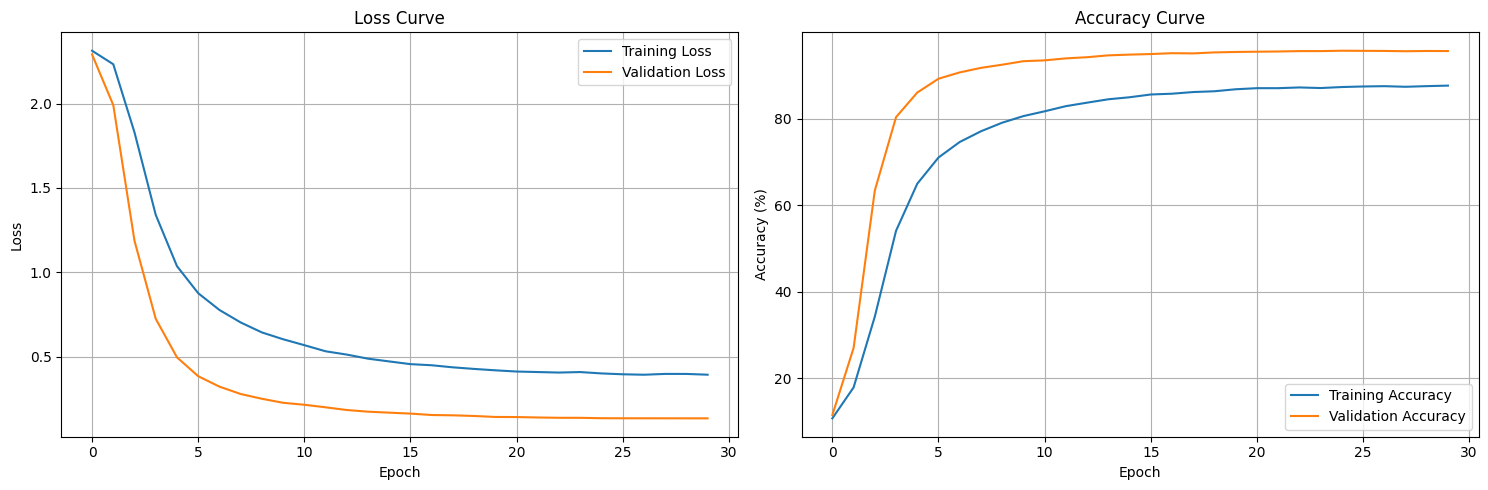

In [249]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss Curve")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label="Training Accuracy")
plt.plot(val_accuracies, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.title("Accuracy Curve")
plt.grid(True)

plt.tight_layout()
plt.show()

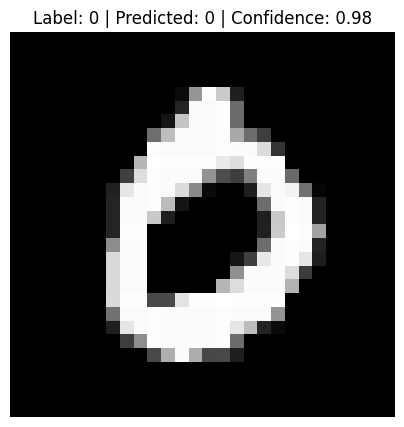

In [330]:
image, label = next(iter(test_loader))
sample_image = image[3].unsqueeze(0).to(device)
sample_label = label[3].item()
vit.eval()
with torch.no_grad():
    outputs, attention_maps = vit(sample_image)

predicted_class = outputs.argmax(dim=1).item()
confidence = outputs[0, predicted_class].item()

plt.figure(figsize=(5, 5))
plt.imshow(image[3].squeeze().cpu().numpy(), cmap="gray")
plt.title(
    f"Label: {sample_label} | Predicted: {predicted_class} | Confidence: {confidence:.2f}"
)
plt.axis("off")
plt.show()

# Attention map visualization

In [331]:
def visualize_attention_maps(image, attention_maps, layer_idx=0):
    num_heads = attention_maps[layer_idx].shape[1]

    fig = plt.figure(figsize=(15, 6))

    if image.shape[1] == 1:  # Grayscale image
        img = image[0, 0].cpu().numpy()
        ax = fig.add_subplot(1, num_heads + 2, 1)
        ax.imshow(img, cmap="gray")
        ax.set_title("Original Image", fontsize=12)
        ax.axis("off")
    else:  # RGB image
        img = image[0].permute(1, 2, 0).cpu().numpy()
        ax = fig.add_subplot(1, num_heads + 2, 1)
        ax.imshow(img)
        ax.set_title("Original Image", fontsize=12)
        ax.axis("off")

    upscaled_attns = []
    for head_idx in range(num_heads):
        attn = attention_maps[layer_idx][0, head_idx].cpu().numpy()
        cls_attn = attn[0, 1:]  # Attention from CLS token to image patches

        n_patches = int(np.sqrt(len(cls_attn)))
        attn_map = cls_attn.reshape(n_patches, n_patches)

        upscaled_attn = scipy.ndimage.zoom(
            attn_map,
            (img.shape[0] / n_patches, img.shape[1] / n_patches),
            order=1,
        )
        upscaled_attns.append(upscaled_attn)

        ax = fig.add_subplot(1, num_heads + 2, head_idx + 2)
        im = ax.imshow(upscaled_attn, cmap="hot")
        ax.set_title(f"Head {head_idx}", fontsize=12)
        ax.axis("off")

    if upscaled_attns:
        combined_attn = np.mean(upscaled_attns, axis=0)
        ax = fig.add_subplot(1, num_heads + 2, num_heads + 2)
        if image.shape[1] == 1:
            ax.imshow(img, cmap="gray")
            im = ax.imshow(combined_attn, cmap="hot", alpha=0.6)
        else:
            ax.imshow(img)
            im = ax.imshow(combined_attn, cmap="hot", alpha=0.6)
        ax.set_title("Combined Overlay", fontsize=12)
        ax.axis("off")
        plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

    plt.tight_layout()
    plt.suptitle(f"Attention Maps for Layer {layer_idx}", fontsize=14)
    plt.subplots_adjust(top=1.3)
    plt.show()

    return upscaled_attns

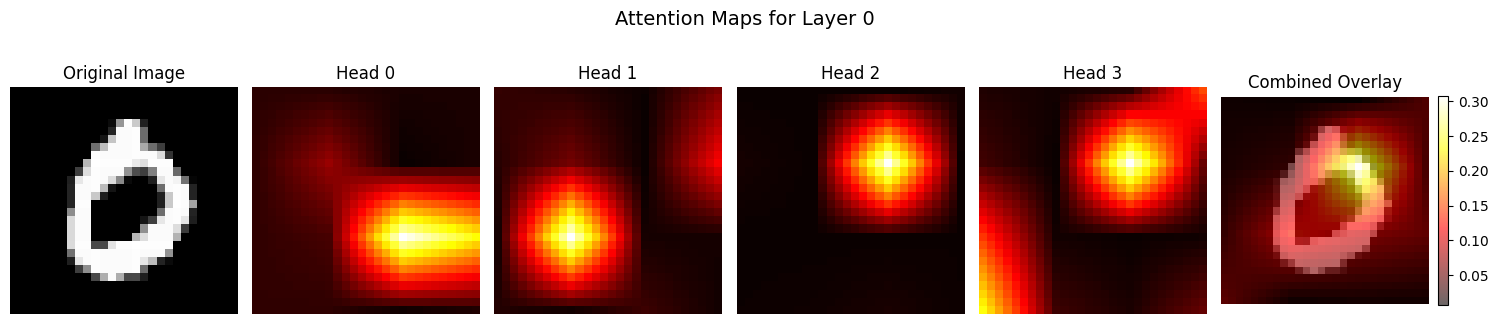

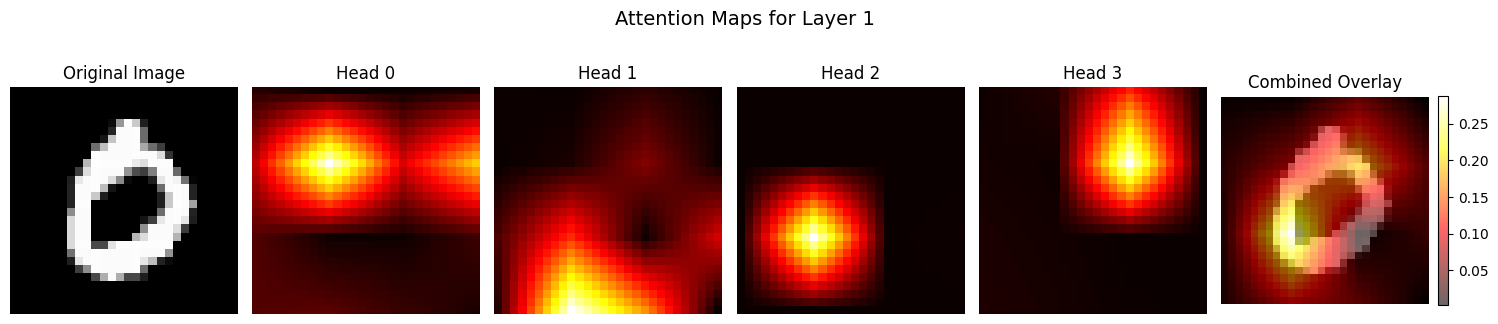

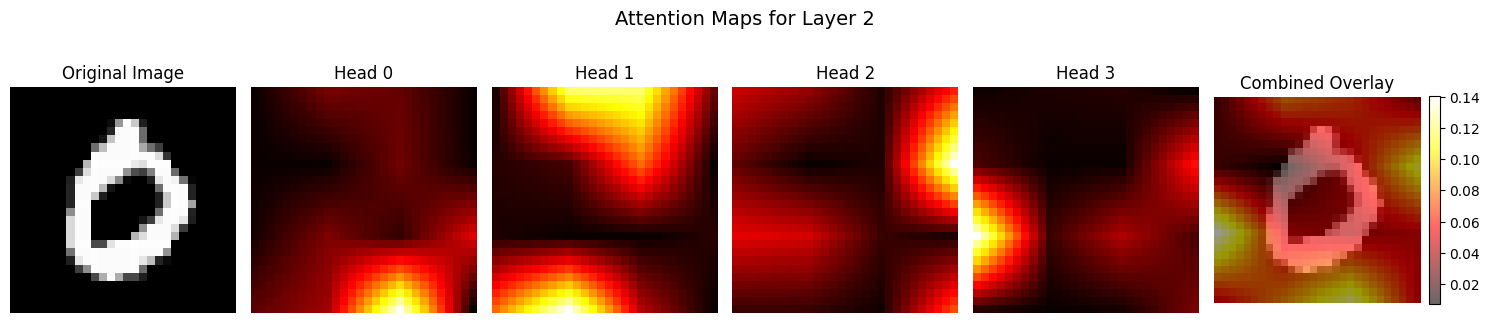

In [332]:
for layer_idx in range(len(attention_maps)):
    _ = visualize_attention_maps(sample_image, attention_maps, layer_idx=layer_idx)